# Ultrasound Nerve Segmentation
## Identify nerve structures in ultrasound images of the neck

The dataset is from a popular Kaggle competition: 
https://www.kaggle.com/c/ultrasound-nerve-segmentation/

It is a very basic approach - I did it just to be sure that my ccn works.

I am using resized images (32 by 32) and a very simple cnn:
* convolution layer with kernel 3 by 3 and 32 filters
* max pool 2 by 2
* convolution layer with kernel 3 by 3 and 64 filters
* upsampling using tf.image.resize_nearest_neighbor 
* convolution layer with kernel 3 by 3 and 32 filters
* the very last layer is a convolution layer with 1 filter and kernel 1 by 1 that help me to get 2D prediction (our mask is black and withe)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import csv
from os import listdir
from os.path import isfile, isdir, join, splitext
import random
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data, color

In [44]:
train = pd.read_csv("tr_data.csv")
n_train = train.shape[0]

test = pd.read_csv("test_data.csv")
n_test = test.shape[0]

In [45]:
train.head(3)

,image,mask
0,1_106.tif,1_106_mask.tif
1,1_64.tif,1_64_mask.tif
2,1_74.tif,1_74_mask.tif


In [46]:
ims_train = []
for i in train['image']:
    a = Image.open('train_subset/' + i)
    a = a.resize((32,32))
    a=np.array(a)
    ims_train.append(a)
ims_train = np.array(ims_train)
ims_train = ims_train.reshape(500, 32,32, 1)
ims_train = ims_train/255
ims_train = np.array( ims_train, dtype=np.float32 ) 

In [47]:
ims_train.shape

(500, 32, 32, 1)

In [48]:
ms_train = []
for i in train['mask']:
    a = Image.open('train_subset/' + i)
    a = a.resize((32,32))
    a=np.array(a)
    ms_train.append(a)
ms_train = np.array(ms_train)
ms_train = ms_train.reshape(500, 32,32, 1)
ms_train = ms_train/255
ms_train = np.array(ms_train, dtype=np.float32 ) 

In [49]:
ms_train.shape

(500, 32, 32, 1)

In [50]:
ims_test = []
for i in test['image']:
    a = Image.open('train_subset/' + i)
    a = a.resize((32,32))
    a=np.array(a)
    ims_test.append(a)
ims_test = np.array(ims_test)
ims_test = ims_test.reshape(-1, 32,32,1)
ims_test = ims_test/255
ims_test = np.array( ims_test, dtype=np.float32 ) 
ims_test.shape

(99, 32, 32, 1)

In [51]:
ms_test = []
for i in test['mask']:
    a = Image.open('train_subset/' + i)
    a = a.resize((32,32))
    a=np.array(a)
    ms_test.append(a)
ms_test = np.array(ms_test)
ms_test = ms_test.reshape(-1, 32,32,1)
ms_test = ms_test/255
ms_test = np.array(ms_test, dtype=np.float32 ) 
ms_test.shape

(99, 32, 32, 1)

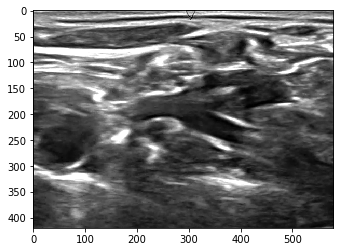

In [121]:
img = Image.open('train_subset/1_106.tif')
#img = img.resize((32,32))
plt.imshow(img, cmap='gist_gray')

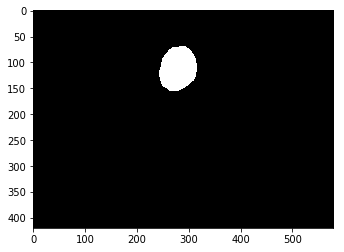

In [122]:
img = Image.open('train_subset/1_106_mask.tif')
#img = img.resize((32,32))
plt.imshow(img, cmap='gist_gray')

In [75]:
x = tf.placeholder(tf.float32,shape=[None,32,32,1])
#y_true = tf.placeholder(tf.float32,shape=[None,10])
y = tf.placeholder(tf.float32, shape=[None, 32,32, 1])

In [76]:
hold_prob = tf.placeholder(tf.float32)

### Helper Functions

In [77]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

Next three function were taken form https://github.com/kkweon/UNet-in-Tensorflow/blob/master/train.py

In [78]:
def upsampling_2D(tensor,  size=(2, 2)):
    """Upsample/Rescale `tensor` by size
    Args:
        tensor (4-D Tensor): (N, H, W, C)
        name (str): name of upsampling operations
        size (tuple, optional): (height_multiplier, width_multiplier)
            (default: (2, 2))
    Returns:
        output (4-D Tensor): (N, h_multiplier * H, w_multiplier * W, C)
    """
    H, W, _ = tensor.get_shape().as_list()[1:]

    H_multi, W_multi = size
    target_H = H * H_multi
    target_W = W * W_multi

    return tf.image.resize_nearest_neighbor(tensor, (target_H, target_W))

In [79]:
def upsample_concat(inputA, input_B):
    """Upsample `inputA` and concat with `input_B`
    Args:
        input_A (4-D Tensor): (N, H, W, C)
        input_B (4-D Tensor): (N, 2*H, 2*H, C2)
        name (str): name of the concat operation
    Returns:
        output (4-D Tensor): (N, 2*H, 2*W, C + C2)
    """
    upsample = upsampling_2D(inputA, size=(2, 2))

    return tf.concat([upsample, input_B], axis=-1)

In [80]:
def IOU_(y_pred, y_true):
    """Returns a (approx) IOU score
    intesection = y_pred.flatten() * y_true.flatten()
    Then, IOU = 2 * intersection / (y_pred.sum() + y_true.sum() + 1e-7) + 1e-7
    Args:
        y_pred (4-D array): (N, H, W, 1)
        y_true (4-D array): (N, H, W, 1)
    Returns:
        float: IOU score
    """
    H, W, _ = y_pred.get_shape().as_list()[1:]

    pred_flat = tf.reshape(y_pred, [-1, H * W])
    true_flat = tf.reshape(y_true, [-1, H * W])

    intersection = 2 * tf.reduce_sum(pred_flat * true_flat, axis=1) + 1e-7
    denominator = tf.reduce_sum(pred_flat, axis=1) + tf.reduce_sum(true_flat, axis=1) + 1e-7

    return tf.reduce_mean(intersection / denominator)

### Create the Layers

** Create a convolutional layer and a pooling layer as we did for MNIST. **
** Its up to you what the 2d size of the convolution should be, but the last two digits need to be 3 and 32 because of the 3 color channels and 32 pixels. So for example you could use:**

        convo_1 = convolutional_layer(x,shape=[4,4,3,32])

In [152]:
convo_1 = convolutional_layer(x,shape=[3,3,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

** Create the next convolutional and pooling layers.  The last two dimensions of the convo_2 layer should be 32,64 **

In [153]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[3,3,32,64]) # images 16*16
#convo_2_pooling = max_pool_2by2(convo_2)

In [154]:
up_1 = upsample_concat(convo_2, convo_1) # image 32*32
convo_3 = convolutional_layer(up_1,shape=[3,3,96,32])

In [155]:
# training prediction
pred = tf.layers.conv2d(convo_3, 1, (1, 1), activation=tf.nn.sigmoid, padding='same')

In [156]:
loss = -IOU_(pred, y)
optim = tf.train.AdamOptimizer(learning_rate=0.001)
train = optim.minimize(loss)

In [157]:
init = tf.global_variables_initializer()

In [172]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_test = []
for i in range(1000):
        offset = (i * 20) % (ims_train.shape[0] - 20) # 20 is the batch size
        batch_x = ims_train[offset:(offset + 20), :]
        batch_y = ms_train[offset:(offset + 20), :]
        _, l, predictions = sess.run([train, loss, pred], feed_dict={x: batch_x, y: batch_y})
        
        # PRINT OUT A MESSAGE EVERY 50 STEPS
        if i%50 == 0:
            loss_train.append(l)
            print("Minibatch loss at step %d: %f" % (i, l))
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            test_l = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
            print(test_l)
            print('\n')
            loss_test.append(test_l)
            
output= sess.run(pred,feed_dict={x: ims_test}) 

Minibatch loss at step 0: -0.022406
Currently on step 0
Accuracy is:
-0.0143336


Minibatch loss at step 50: -0.042118
Currently on step 50
Accuracy is:
-0.048956


Minibatch loss at step 100: -0.013680
Currently on step 100
Accuracy is:
-0.0955926


Minibatch loss at step 150: -0.132457
Currently on step 150
Accuracy is:
-0.0838636


Minibatch loss at step 200: -0.178224
Currently on step 200
Accuracy is:
-0.114119


Minibatch loss at step 250: -0.126784
Currently on step 250
Accuracy is:
-0.104243


Minibatch loss at step 300: -0.124960
Currently on step 300
Accuracy is:
-0.112746


Minibatch loss at step 350: -0.095188
Currently on step 350
Accuracy is:
-0.126032


Minibatch loss at step 400: -0.183895
Currently on step 400
Accuracy is:
-0.128814


Minibatch loss at step 450: -0.084558
Currently on step 450
Accuracy is:
-0.126254


Minibatch loss at step 500: -0.031854
Currently on step 500
Accuracy is:
-0.135872


Minibatch loss at step 550: -0.129568
Currently on step 550
Accuracy

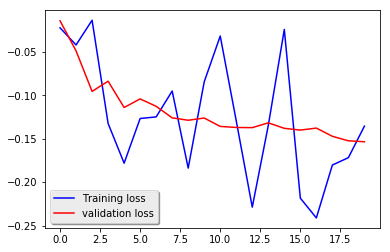

In [173]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, color='b', label="Training loss")
ax.plot(loss_test, color='r', label="validation loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

Looking at this graph I would say that we need to decrease the learning rate and increase the number of steps.

In [158]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for i in range(1000):
        offset = (i * 20) % (ims_train.shape[0] - 20) # 20 is the batch size
        batch_x = ims_train[offset:(offset + 20), :]
        batch_y = ms_train[offset:(offset + 20), :]
        _, l, predictions = sess.run([train, loss, pred], feed_dict={x: batch_x, y: batch_y})
        
        # PRINT OUT A MESSAGE EVERY 5 STEPS
        if i%50 == 0:
            print("Minibatch loss at step %d: %f" % (i, l))
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:ims_test,y:ms_test,hold_prob:1.0}))
            print('\n')
output3= sess.run(pred,feed_dict={x: ims_test}) 

Minibatch loss at step 0: -0.020192
Currently on step 0
Accuracy is:
0.00189394


Minibatch loss at step 50: -0.047679
Currently on step 50
Accuracy is:
0.0287247


Minibatch loss at step 100: -0.011333
Currently on step 100
Accuracy is:
0.0460859


Minibatch loss at step 150: -0.135714
Currently on step 150
Accuracy is:
0.0697601


Minibatch loss at step 200: -0.170044
Currently on step 200
Accuracy is:
0.0991162


Minibatch loss at step 250: -0.122891
Currently on step 250
Accuracy is:
0.146465


Minibatch loss at step 300: -0.141432
Currently on step 300
Accuracy is:
0.171402


Minibatch loss at step 350: -0.093891
Currently on step 350
Accuracy is:
0.122159


Minibatch loss at step 400: -0.177966
Currently on step 400
Accuracy is:
0.0988005


Minibatch loss at step 450: -0.090490
Currently on step 450
Accuracy is:
0.10101


Minibatch loss at step 500: -0.038988
Currently on step 500
Accuracy is:
0.0890151


Minibatch loss at step 550: -0.117822
Currently on step 550
Accuracy is:
0.

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Predicted Mask

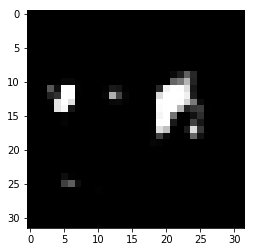

In [175]:
plt.imshow(output[97].reshape(32, 32),cmap='gist_gray')

### Actual Mask

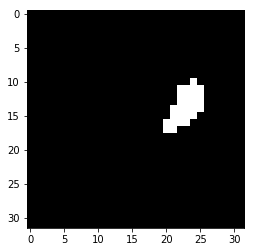

In [139]:
plt.imshow(ms_test[97].reshape(32, 32),cmap='gist_gray')

### Image

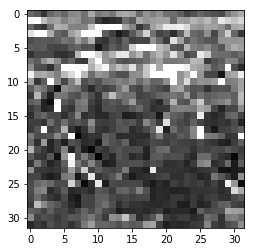

In [140]:
plt.imshow(ims_test[97].reshape(32, 32),cmap='gist_gray')

## Next steps
1. Increase the numbers of layers
2. Increse the size of images up to 64 by 64
3. Increse the number of iterrations 
4. Try some different learning rates (I think, we need to decrease it)